# 05 - VGG16 Transfer Learning: Reproduction Model 331

**Objectif:** Reproduire F1 = 0.60 (Model 331 original)

**Architecture:** VGG16 (ImageNet) + Classifier Head | **Images:** 224×224 | **Batch:** 64

**Stratégie 2-Phase:**
- Phase 1: VGG16 gelé, entraînement classifier (~14 époques)
- Phase 2: Dégeler 4 dernières couches VGG16, fine-tuning (~10 époques)

**🔵 Optimisé pour Google Colab + Keras 3**

---

## 🔧 Environnement

In [1]:
import sys, os
from pathlib import Path

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("🔵 Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path('/content/drive/MyDrive/sep25_alt1_mle_ds_rakuten')
    os.chdir(PROJECT_ROOT)
else:
    print("🟢 Local")
    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    os.chdir(PROJECT_ROOT)

print(f"📁 {PROJECT_ROOT}")

🔵 Google Colab
Mounted at /content/drive
📁 /content/drive/MyDrive/sep25_alt1_mle_ds_rakuten


## 📦 Imports

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import pickle, json, shutil
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

# GPU check
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
if gpus:
    print(f"✅ GPU: {gpus}")
else:
    print("❌ Pas de GPU! → Runtime > Change runtime type > T4 GPU")

INPUT_DIR  = Path('output/03_preprocessing_resampling')
OUTPUT_DIR = Path('output/05_vgg16_transfer')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("\n✅ Imports OK")

TensorFlow: 2.19.0
✅ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Imports OK


## 🏷️ Labels Catégories

In [3]:
# Labels des catégories
prdtypecode_labels = {
    10: "Livre usagé",
    40: "Jeux vidéo et accessoires tech",
    50: "Accessoires de console",
    60: "Console de jeux vidéo",
    1140: "Statuette / Figurine",
    1160: "Cartes collectionnables",
    1180: "Jeux de table",
    1280: "Jouets enfants et costumes",
    1281: "Jeux de société",
    1300: "Jouets électroniques",
    1301: "Bas et chaussettes",
    1302: "Jeux extérieurs et vêtements",
    1320: "Articles pour bébé",
    1560: "Meubles intérieurs",
    1920: "Mobilier de chambre",
    1940: "Ustensiles de cuisine",
    2060: "Décoration intérieure",
    2220: "Produits pour animaux",
    2280: "Magazines et journaux",
    2403: "Livres, magazines et BD",
    2462: "Jeux d'occasion",
    2522: "Matériel de bureau",
    2582: "Mobilier de jardin",
    2583: "Équipement de piscine",
    2585: "Outillage et bricolage",
    2705: "Livre nouveau",
    2905: "Jeux pour PC"
}

print("✅ Labels définis")

✅ Labels définis


## 🚀 Copie Images → SSD Colab

**CRITIQUE:** Les images sont sur Drive (lent). On les copie sur le SSD local de Colab (rapide).

⏱️ La copie prend 10-20 min **une seule fois par session**.

In [4]:
DRIVE_IMAGE_DIR = Path('output/02_preprocessing_images/images_zoomed')
SSD_IMAGE_DIR   = Path('/content/images_zoomed')

if IS_COLAB:
    if not SSD_IMAGE_DIR.exists():
        print(f"📦 Copie Drive → SSD Colab...")
        print(f"   Source: {DRIVE_IMAGE_DIR}")
        print(f"   Dest:   {SSD_IMAGE_DIR}")
        print(f"   ⏱️  ~10-20 minutes, une seule fois par session\n")
        shutil.copytree(src=DRIVE_IMAGE_DIR, dst=SSD_IMAGE_DIR)
        print(f"\n✅ Copie terminée!")
    else:
        print(f"✅ Images déjà sur SSD: {SSD_IMAGE_DIR}")
    IMAGE_DIR = SSD_IMAGE_DIR
else:
    # Local: use Drive images directly (fast local disk)
    IMAGE_DIR = DRIVE_IMAGE_DIR

# Verify
n_classes_found = len(list(IMAGE_DIR.iterdir())) if IMAGE_DIR.exists() else 0
print(f"🚀 IMAGE_DIR = {IMAGE_DIR}")
print(f"   Dossiers classes trouvés: {n_classes_found}")

📦 Copie Drive → SSD Colab...
   Source: output/02_preprocessing_images/images_zoomed
   Dest:   /content/images_zoomed
   ⏱️  ~10-20 minutes, une seule fois par session


✅ Copie terminée!
🚀 IMAGE_DIR = /content/images_zoomed
   Dossiers classes trouvés: 27


## ⚙️ Configuration

In [5]:
MODEL_ID = "vgg16_model_331"

CONFIG = {
    'model_id': MODEL_ID,
    'image_size': (224, 224, 3),  # VGG16 standard
    'batch_size': 64,
    'phase1_epochs': 20,  # Frozen VGG16
    'phase2_epochs': 10,  # Fine-tuning
    'phase1_lr': 0.001,
    'phase2_lr': 0.0001,
    'dropout_rate': 0.2,
}

AUGMENTATION = {
    'preprocessing_function': preprocess_input,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 5,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'nearest'
}

print(f"📋 VGG16 Transfer Learning - Model 331 Reproduction")
print(f"   Images: {CONFIG['image_size'][:2]} | Batch: {CONFIG['batch_size']}")
print(f"   Phase 1: {CONFIG['phase1_epochs']} époques (VGG16 gelé, LR={CONFIG['phase1_lr']})")
print(f"   Phase 2: {CONFIG['phase2_epochs']} époques (4 dernières couches dégelées, LR={CONFIG['phase2_lr']})")

📋 VGG16 Transfer Learning - Model 331 Reproduction
   Images: (224, 224) | Batch: 64
   Phase 1: 20 époques (VGG16 gelé, LR=0.001)
   Phase 2: 10 époques (4 dernières couches dégelées, LR=0.0001)


## 📊 Chargement Données

In [6]:
df_train = pd.read_csv(INPUT_DIR / 'df_train.csv', index_col=0)
df_val   = pd.read_csv(INPUT_DIR / 'df_val.csv',   index_col=0)
df_test  = pd.read_csv(INPUT_DIR / 'df_test.csv',  index_col=0)

# prdtypecode doit être string pour flow_from_dataframe
for df in [df_train, df_val, df_test]:
    df['prdtypecode'] = df['prdtypecode'].astype(str)

classes     = sorted(df_train['prdtypecode'].unique(), key=lambda x: int(x))
num_classes = len(classes)

print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
print(f"Classes: {num_classes}")

Train: 109,566 | Val: 8,492 | Test: 8,492
Classes: 27


## 🖼️ Générateurs

In [7]:
train_datagen = ImageDataGenerator(**AUGMENTATION)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=True, seed=42
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

print(f"\n✅ Train: {train_gen.samples:,} | Val: {val_gen.samples:,} | Test: {test_gen.samples:,}")

Found 109566 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.

✅ Train: 109,566 | Val: 8,492 | Test: 8,492


## 🏗️ Architecture VGG16 + Classifier

In [8]:
def build_vgg16_model(input_shape, num_classes, dropout_rate=0.2):
    """
    VGG16 (ImageNet) + Custom Classifier Head
    Tous les layers VGG16 sont gelés initialement
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Geler tous les layers VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Classifier head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ], name='VGG16_Transfer')

    return model

print("✅ Architecture VGG16 définie")

✅ Architecture VGG16 définie


## 🔄 Checkpoints

In [9]:
class CheckpointManager:
    def __init__(self, model_id, output_dir):
        self.model_id     = model_id
        self.output_dir   = Path(output_dir)
        self.phase1_path  = self.output_dir / f"{model_id}_phase1.keras"
        self.phase2_path  = self.output_dir / f"{model_id}_phase2.keras"
        self.history_path = self.output_dir / f"{model_id}_history.pkl"
        self.log_path     = self.output_dir / f"{model_id}_log.json"
        self.log          = self._load_log()

    def _load_log(self):
        if self.log_path.exists():
            with open(self.log_path) as f: return json.load(f)
        return {'model_id': self.model_id, 'created_at': datetime.now().isoformat(),
                'phase1_done': False, 'phase2_done': False,
                'phase1_best_f1': 0.0, 'phase2_best_f1': 0.0}

    def save_log(self):
        with open(self.log_path, 'w') as f: json.dump(self.log, f, indent=2)

    def save_phase1(self, model):
        model.save(self.phase1_path)
        print(f"💾 Phase 1 sauvegardée: {self.phase1_path.name}")

    def save_phase2(self, model):
        model.save(self.phase2_path)
        print(f"💾 Phase 2 sauvegardée: {self.phase2_path.name}")

    def load_phase1(self):
        if self.phase1_path.exists():
            print(f"📂 Chargement Phase 1: {self.phase1_path.name}")
            return load_model(self.phase1_path)
        return None

    def load_phase2(self):
        if self.phase2_path.exists():
            print(f"📂 Chargement Phase 2: {self.phase2_path.name}")
            return load_model(self.phase2_path)
        return None

    def save_history(self, history_dict):
        existing = self.load_history() or {}
        for k, v in history_dict.items():
            existing[k] = existing.get(k, []) + (v if isinstance(v, list) else list(v))
        with open(self.history_path, 'wb') as f: pickle.dump(existing, f)

    def load_history(self):
        if self.history_path.exists():
            with open(self.history_path, 'rb') as f: return pickle.load(f)
        return None

checkpoint = CheckpointManager(MODEL_ID, OUTPUT_DIR)
print(f"✅ Checkpoint | Phase 1: {checkpoint.log['phase1_done']} | Phase 2: {checkpoint.log['phase2_done']}")

✅ Checkpoint | Phase 1: False | Phase 2: False


## 📝 Callbacks

In [10]:
class F1Callback(Callback):
    def __init__(self, val_gen, checkpoint, phase):
        super().__init__()
        self.val_gen    = val_gen
        self.checkpoint = checkpoint
        self.phase      = phase
        self.best_f1    = 0.0
        self.history    = {'train_loss': [], 'train_acc': [],
                           'val_loss': [], 'val_acc': [], 'val_f1': []}

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        y_pred_proba = self.model.predict(self.val_gen, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = self.val_gen.classes
        val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        self.history['train_loss'].append(float(logs.get('loss', 0)))
        self.history['train_acc'].append(float(logs.get('accuracy', 0)))
        self.history['val_loss'].append(float(logs.get('val_loss', 0)))
        self.history['val_acc'].append(float(logs.get('val_accuracy', 0)))
        self.history['val_f1'].append(float(val_f1))

        print(f"  → val_f1: {val_f1:.4f}", end='')

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.checkpoint.log[f'{self.phase}_best_f1'] = float(val_f1)
            self.checkpoint.log[f'{self.phase}_best_epoch'] = epoch + 1
            if self.phase == 'phase1':
                self.checkpoint.save_phase1(self.model)
            else:
                self.checkpoint.save_phase2(self.model)
            print(f" 🎯 Nouveau meilleur!", end='')

        print()
        self.checkpoint.save_log()

print("✅ Callbacks définis")

✅ Callbacks définis


In [11]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    min_delta=0.01,
    verbose=1
)

print("✅ Early Stopping défini")

✅ Early Stopping défini


## 🏃 PHASE 1: Entraînement Classifier (VGG16 Gelé)

**⏱️ Durée: ~2-3 heures sur T4**

In [12]:
model = checkpoint.load_phase1()

if model is None and not checkpoint.log['phase1_done']:
    print("\n🏗️ Construction VGG16 (Phase 1)...")
    model = build_vgg16_model(CONFIG['image_size'], num_classes, CONFIG['dropout_rate'])
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['phase1_lr']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Compilé")

if model is not None:
    model.summary()


🏗️ Construction VGG16 (Phase 1)...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✅ Compilé


Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,778,651 (60.19 MB)

 Trainable params: 1,063,963 (4.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
if not checkpoint.log['phase1_done']:
    print(f"\n🎯 PHASE 1: Entraînement avec VGG16 gelé...\n")

    f1_cb = F1Callback(val_gen, checkpoint, 'phase1')

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['phase1_epochs'],
        steps_per_epoch=train_gen.samples // CONFIG['batch_size'],
        validation_steps=val_gen.samples // CONFIG['batch_size'],
        callbacks=[f1_cb, early_stopping],
        verbose=1
    )

    checkpoint.log['phase1_done'] = True
    checkpoint.save_log()
    checkpoint.save_history(f1_cb.history)

    print("\n✅ Phase 1 terminée!")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")
else:
    print("\n⏭️ Phase 1 déjà terminée")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")


🎯 PHASE 1: Entraînement avec VGG16 gelé...

Epoch 1/20
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.3693 - loss: 2.2624  → val_f1: 0.5038💾 Phase 1 sauvegardée: vgg16_model_331_phase1.keras
 🎯 Nouveau meilleur!
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 874s 505ms/step - accuracy: 0.3693 - loss: 2.2622 - val_accuracy: 0.4941 - val_loss: 1.7023
Epoch 2/20
   1/1711 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.3750 - loss: 1.7403  → val_f1: 0.5012
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.3750 - loss: 1.7403 - val_accuracy: 0.4909 - val_loss: 1.7112
Epoch 3/20
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5091 - loss: 1.6272  → val_f1: 0.5208💾 Phase 1 sauvegardée: vgg16_model_331_phase1.keras
 🎯 Nouveau meilleur!
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 831s 486ms/step - accuracy: 0.5091 - loss: 1.6272 - val_accuracy: 0.5110 - val_loss: 1.6865
Epoch 4/20
   1/1711 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5781 - loss: 1.3782  → val_f1: 0.5223💾 Phase 1 sau

## 🔓 PHASE 2: Fine-Tuning (Dégeler 4 Dernières Couches VGG16)

**⏱️ Durée: ~1-2 heures sur T4**

In [14]:
if checkpoint.log['phase1_done'] and not checkpoint.log['phase2_done']:
    print("\n🔓 PHASE 2: Préparation fine-tuning...")

    # Charger meilleur modèle Phase 1
    model = checkpoint.load_phase1()

    # Dégeler 4 dernières couches VGG16
    vgg_base = model.layers[0]
    for layer in vgg_base.layers[-4:]:
        layer.trainable = True

    print(f"   Couches dégelées: {[l.name for l in vgg_base.layers if l.trainable]}")

    # Recompiler avec LR plus bas
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['phase2_lr']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"✅ Recompilé avec LR={CONFIG['phase2_lr']}")
    print(f"\n📊 Paramètres entraînables: {model.count_params():,}")


🔓 PHASE 2: Préparation fine-tuning...
📂 Chargement Phase 1: vgg16_model_331_phase1.keras
   Couches dégelées: ['input_layer', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
✅ Recompilé avec LR=0.0001

📊 Paramètres entraînables: 15,778,651


In [15]:
if checkpoint.log['phase1_done'] and not checkpoint.log['phase2_done']:
    print(f"\n🎯 PHASE 2: Fine-tuning VGG16...\n")

    f1_cb = F1Callback(val_gen, checkpoint, 'phase2')

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['phase2_epochs'],
        steps_per_epoch=train_gen.samples // CONFIG['batch_size'],
        validation_steps=val_gen.samples // CONFIG['batch_size'],
        callbacks=[f1_cb, early_stopping],
        verbose=1
    )

    checkpoint.log['phase2_done'] = True
    checkpoint.save_log()
    checkpoint.save_history(f1_cb.history)

    print("\n✅ Phase 2 terminée!")
    print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")
else:
    print("\n⏭️ Phase 2 déjà terminée ou Phase 1 non terminée")
    if checkpoint.log['phase2_done']:
        print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")


🎯 PHASE 2: Fine-tuning VGG16...

Epoch 1/10
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5628 - loss: 1.4521  → val_f1: 0.5616💾 Phase 2 sauvegardée: vgg16_model_331_phase2.keras
 🎯 Nouveau meilleur!
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 871s 506ms/step - accuracy: 0.5628 - loss: 1.4520 - val_accuracy: 0.5533 - val_loss: 1.5025
Epoch 2/10
   1/1711 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6094 - loss: 1.3732  → val_f1: 0.5602
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.6094 - loss: 1.3732 - val_accuracy: 0.5520 - val_loss: 1.5012
Epoch 3/10
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6333 - loss: 1.1870  → val_f1: 0.5724💾 Phase 2 sauvegardée: vgg16_model_331_phase2.keras
 🎯 Nouveau meilleur!
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 872s 509ms/step - accuracy: 0.6333 - loss: 1.1870 - val_accuracy: 0.5672 - val_loss: 1.4611
Epoch 4/10
   1/1711 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.5781 - loss: 1.3995  → val_f1: 0.5729💾 Phase 2 sauvegardée: v

## 📊 Courbes d'Entraînement

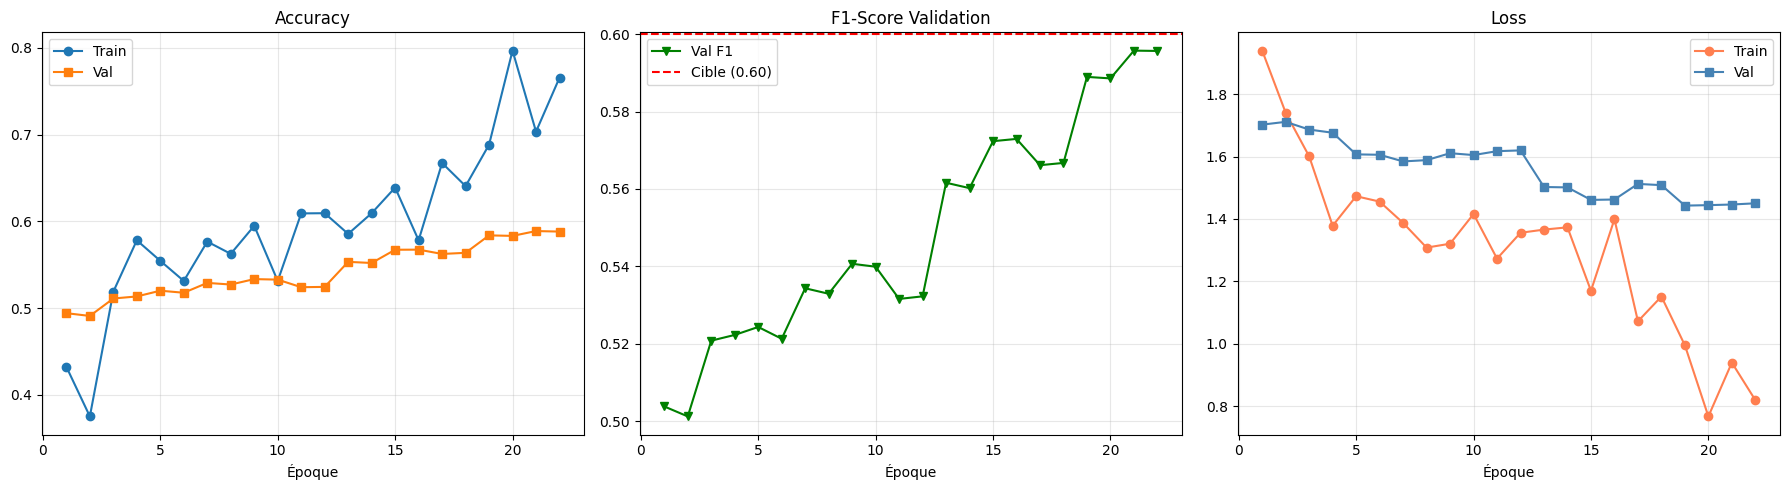

Meilleur val F1: 0.5958 (époque 21)


In [16]:
history = checkpoint.load_history()

if history:
    epochs_range = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(epochs_range, history['train_acc'], label='Train', marker='o')
    axes[0].plot(epochs_range, history['val_acc'],   label='Val',   marker='s')
    axes[0].set_title('Accuracy'); axes[0].set_xlabel('Époque')
    axes[0].legend(); axes[0].grid(alpha=0.3)

    axes[1].plot(epochs_range, history['val_f1'], label='Val F1', marker='v', color='green')
    axes[1].axhline(y=0.60, color='red', linestyle='--', label='Cible (0.60)')
    axes[1].set_title('F1-Score Validation'); axes[1].set_xlabel('Époque')
    axes[1].legend(); axes[1].grid(alpha=0.3)

    axes[2].plot(epochs_range, history['train_loss'], label='Train', marker='o', color='coral')
    axes[2].plot(epochs_range, history['val_loss'],   label='Val',   marker='s', color='steelblue')
    axes[2].set_title('Loss'); axes[2].set_xlabel('Époque')
    axes[2].legend(); axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    best_epoch = int(np.argmax(history['val_f1'])) + 1
    print(f"Meilleur val F1: {max(history['val_f1']):.4f} (époque {best_epoch})")
else:
    print("Pas d'historique trouvé")

## 🎯 Évaluation Test

In [17]:
# Charger le meilleur modèle (Phase 2 si terminée, sinon Phase 1)
if checkpoint.log['phase2_done']:
    model = checkpoint.load_phase2()
    print("📂 Évaluation avec modèle Phase 2 (fine-tuned)")
elif checkpoint.log['phase1_done']:
    model = checkpoint.load_phase1()
    print("📂 Évaluation avec modèle Phase 1 (VGG16 gelé)")
else:
    print("❌ Aucun modèle entraîné à évaluer")
    model = None

if model is not None:
    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_gen.classes

    test_f1  = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    test_acc = accuracy_score(y_true, y_pred)

    print(f"\n📊 Test - F1: {test_f1:.4f} | Accuracy: {test_acc:.4f}")

    checkpoint.log['test_f1']  = float(test_f1)
    checkpoint.log['test_acc'] = float(test_acc)
    checkpoint.save_log()

📂 Chargement Phase 2: vgg16_model_331_phase2.keras
📂 Évaluation avec modèle Phase 2 (fine-tuned)
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step

📊 Test - F1: 0.5986 | Accuracy: 0.5909


## 📋 Rapport & Matrice Confusion

In [18]:
if model is not None:
    class_labels = [prdtypecode_labels[int(c)] for c in classes]

    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print(report)
    with open(OUTPUT_DIR / 'classification_report.txt', 'w') as f:
        f.write(report)
    print("✅ Sauvegardé: classification_report.txt")

                                precision    recall  f1-score   support

                   Livre usagé     0.4030    0.4277    0.4150       311
Jeux vidéo et accessoires tech     0.5928    0.5219    0.5551       251
        Accessoires de console     0.4317    0.4702    0.4501       168
         Console de jeux vidéo     0.5922    0.7349    0.6559        83
          Statuette / Figurine     0.6097    0.6142    0.6119       267
       Cartes collectionnables     0.9144    0.9167    0.9155       396
                 Jeux de table     0.2500    0.3553    0.2935        76
    Jouets enfants et costumes     0.4825    0.3121    0.3791       487
               Jeux de société     0.3013    0.3333    0.3165       207
          Jouets électroniques     0.6383    0.7129    0.6735       505
            Bas et chaussettes     0.6000    0.5926    0.5963        81
  Jeux extérieurs et vêtements     0.3538    0.5100    0.4178       249
            Articles pour bébé     0.4417    0.5031    0.4704  

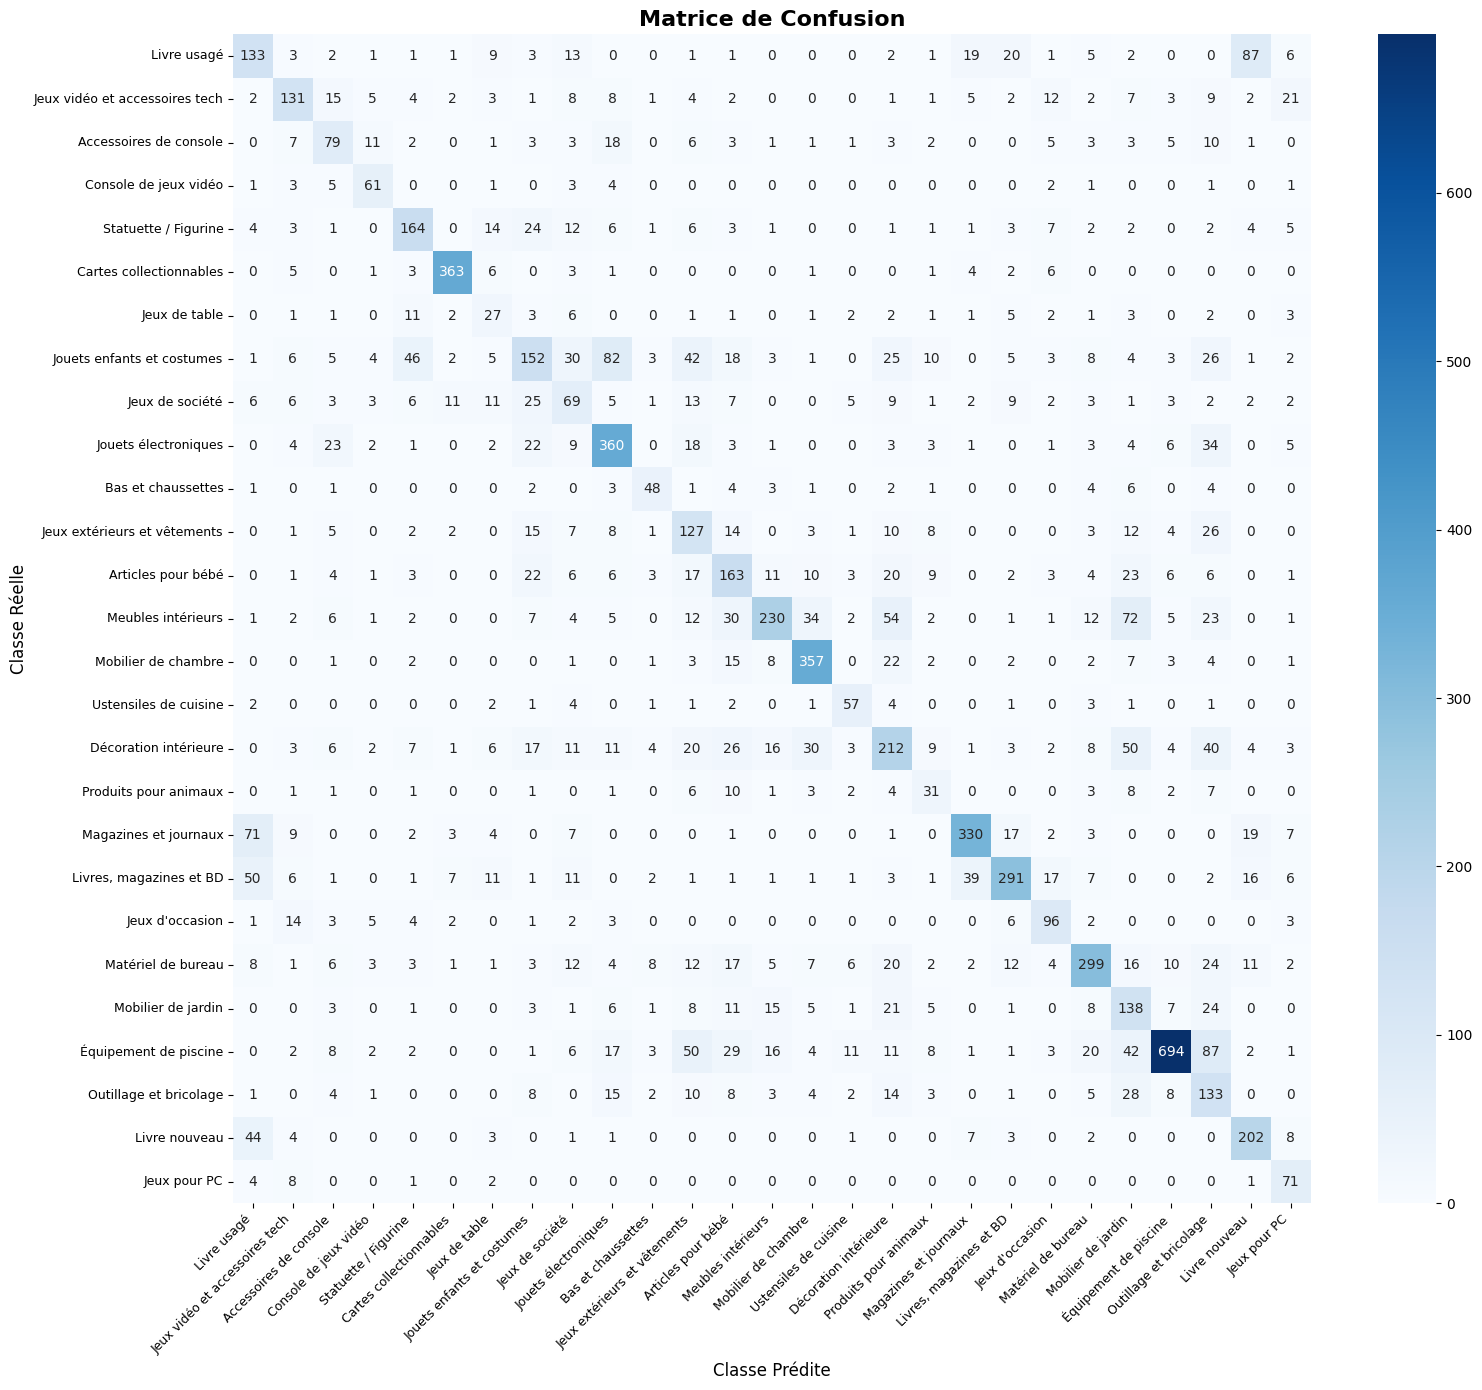

In [19]:
if model is not None:
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matrice de Confusion', fontsize=16, fontweight='bold')
    plt.xlabel('Classe Prédite', fontsize=12)
    plt.ylabel('Classe Réelle', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

## 📋 Résumé Final

In [20]:
if model is not None:
    print("=" * 70)
    print("🏆 RÉSULTATS FINAUX - VGG16 TRANSFER LEARNING")
    print("=" * 70)
    print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
    print(f"\n📊 Phase 1 (VGG16 gelé):")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")
    if checkpoint.log['phase2_done']:
        print(f"\n📊 Phase 2 (Fine-tuning):")
        print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")
    print(f"\n🎯 Test:")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Accuracy: {test_acc:.4f}")

    diff = test_f1 - 0.60
    print(f"\n📈 Comparaison:")
    print(f"   Original (Model 331): 0.6000")
    print(f"   Notre modèle:         {test_f1:.4f}")
    print(f"   Différence:           {diff:+.4f} ({diff/0.60*100:+.1f}%)")

    if abs(diff) <= 0.02:
        print("   ✅ Reproduction réussie! (±2%)")
    elif test_f1 > 0.60:
        print("   🎉 Performance dépassée!")
    else:
        print("   ⚠️ En dessous - vérifier entraînement")

    print(f"\n📁 Sorties: {OUTPUT_DIR}")
    print("=" * 70)

🏆 RÉSULTATS FINAUX - VGG16 TRANSFER LEARNING
Train: 109,566 | Val: 8,492 | Test: 8,492

📊 Phase 1 (VGG16 gelé):
   Meilleur val F1: 0.5407

📊 Phase 2 (Fine-tuning):
   Meilleur val F1: 0.5958

🎯 Test:
   F1-Score: 0.5986
   Accuracy: 0.5909

📈 Comparaison:
   Original (Model 331): 0.6000
   Notre modèle:         0.5986
   Différence:           -0.0014 (-0.2%)
   ✅ Reproduction réussie! (±2%)

📁 Sorties: output/05_vgg16_transfer
